# Run a REopt API evaluation

## Initialization

In [48]:
import pandas as pd
import numpy as np
import json
import requests
import copy
import os
from src.post_and_poll import get_api_results
API_KEY = 'uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC'  # REPLACE WITH YOUR API KEY

In [49]:
# following is not necessary but silences warnings:
# InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.nrel.gov'. Adding certificate verification is strongly advised.
import urllib3
urllib3.disable_warnings()

In [50]:
"""
Here are some convenience definitions for using the Multi-scenario capabilities
"""
##############################################################################################################
inputs_path = os.path.join(".", 'inputs')
outputs_path = os.path.join(".", 'outputs')
loads_path = os.path.join(".", 'load_profiles')
rates_path = os.path.join(".", 'electric_rates')
##############################################################################################################

## Load a previously saved API response .json file instead of running REopt

In [ ]:
response_json = 'results'
with open(os.path.join(outputs_path, response_json + '.json'), 'rb') as handle:
    api_response = json.load(handle)

## Scenario Inputs (POST), if wanting to do a new API call

In [ ]:
post_1 = {
    "Site": {
        "latitude": 37.78,
        "longitude": -122.45
    },
    "ElectricLoad": {
        "doe_reference_name": "Hospital"
    },    
    "CoolingLoad": {
        "doe_reference_name": "LargeOffice"
    },    
    "ElectricTariff": {
        "blended_annual_energy_rate": 0.1,
        "blended_annual_demand_rate": 10
    },
    "ExistingChiller": {
    },
    "PV": {
        "max_kw": 0
    },    
    "ElectricStorage": {
        "max_kwh": 0,
        "max_kw": 0
    }    
}

### Load in a custom electric rate generated from https://reopt.nrel.gov/tool/custom_tariffs

In [ ]:
load_electric_rate = "PGE_E20"
with open(os.path.join(rates_path, load_electric_rate + ".json"), 'r') as fp:
    rate_1 = json.load(fp)
post_1["Scenario"]["Site"]["ElectricTariff"]["urdb_response"] = rate_1

## Save the POST to a .json file for sharing or future loading in

In [ ]:
# Convert python dictionary post into json and save to a .json file
post_save = post_1
post_name = "post_1"
with open(os.path.join(inputs_path, post_name + ".json"), 'w') as fp:
    json.dump(post_save, fp)

## Or load in a saved .json file for the inputs/POST

In [51]:
# Load a json into a python dictionary
load_post = "dev_web_sample_site_resilience_with_generator_inputs"
with open(os.path.join(inputs_path, load_post + ".json"), 'r') as fp:
    post_1 = json.load(fp)

## POST and poll (periodic GET request) the API to GET a new result, if not loading in a previous response. This may take a while!

### Note, the `api_url` in the `get_api_results` function below calls the **production server** hosted API (master/main branch/version, publicly accessible)

#### For calling a locally-hosted (localhost) API, see:
- https://github.com/NREL/REopt_Lite_API/wiki/localhost-URLs-for-calling-locally-hosted-API

#### For calling an API hosted on an NREL-internal server (only NREL users can access this), see:
- https://github.nrel.gov/REopt/API_scripts/wiki/API-URLs-for-NREL-internal-servers

`get_api_results` POST's your inputs to the API `job` endpoint, which provides a `run_uuid` if the input is valid, and then polls the `results` endpoint using the `run_uuid` until the results come back with a status other than `Optimizing...`.

`get_api_results` also saves the results (full API response, including inputs) to the `results_file`.

A log file is also created in the current working directory.

In [54]:
outputs_file_name = "dev_web_sample_results"
#root_url = "https://developer.nrel.gov/api/reopt/stable"
root_url = "http://host.docker.internal:8000/dev"
api_response = get_api_results(post=post_1, 
                               API_KEY=API_KEY, 
                               api_url=root_url, 
                               results_file=os.path.join(outputs_path, outputs_file_name + ".json"), 
                               run_id=None)

main         INFO     Response OK from http://host.docker.internal:8000/dev/job/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC.
main         INFO     Polling http://host.docker.internal:8000/dev/job/c925c365-e507-415f-a665-e54ae010dfbd/results/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC for results with interval of 5s...
main         INFO     Saved results to ./outputs/dev_web_sample_results.json


### If you get disconnected from the polling function but you think it ran, copy the run_uuid from the log above to manually GET the results:

In [ ]:
run_uuid = api_response["run_uuid"]
results_url = root_url + '/job/' + run_uuid + '/results/?api_key=' + API_KEY
resp = requests.get(url=results_url, verify=False)
api_response = json.loads(resp.text)

## Get summary of results

In [55]:
print("NPV ($) = ", api_response["outputs"]["Financial"]["npv"])
print("Capital Cost, Net ($) = ", api_response["outputs"]["Financial"]["lifecycle_capital_costs"])
tech_list = ["PV", "Wind", "ElectricStorage", "CHP", "Generator", "HotThermalStorage", "ColdThermalStorage", "AbsorptionChiller", "GHP", "NewBoiler", "SteamTurbine"]
for tech in tech_list:
    if tech in post_1.keys():# and post_1[tech]["max_kw"]>0.0:
        if tech == "GHP":
            print("GHX Number of Boreholes = ", api_response["outputs"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
            print("GHP Heat Pump Capacity (ton) = ", api_response["outputs"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
        # PV and Storage are considered if the POST does not explicitly make max_[size] == 0
        for size_name_value in [(key, val) for key, val in api_response["outputs"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])
    elif tech in ["PV", "ElectricStorage"]:# and (post_1[tech]["max_kw"]>0.0):
        for size_name_value in [(key, val) for key, val in api_response["outputs"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])                     

NPV ($) =  3235050.79
Capital Cost, Net ($) =  4137078.5662
PV size_kw  =  2863.679
ElectricStorage size_kw  =  538.92
ElectricStorage size_kwh  =  3095.8
Generator size_kw  =  0.0


In [56]:
pv_total_kw_series = [api_response["outputs"]["PV"]["year_one_to_load_series_kw"][i] + 
                    api_response["outputs"]["PV"]["year_one_to_battery_series_kw"][i] + 
                    api_response["outputs"]["PV"]["year_one_to_grid_series_kw"][i] + 
                    api_response["outputs"]["PV"]["year_one_curtailed_production_series_kw"][i] for i in range(len(api_response["outputs"]["PV"]["year_one_to_load_series_kw"]))]
pv_production_factor = [prod_kw / api_response["outputs"]["PV"]["size_kw"] for prod_kw in pv_total_kw_series]


### Run the ERP tool with REopt results and inputs

In [57]:
0 or 500

500

In [58]:
post_erp = {
        "reopt_run_uuid": api_response["run_uuid"],
        "generator_operational_availability": 0.9998, 
        "generator_failure_to_start" : 0.0066, 
        "generator_failure_to_run" : 0.00157,
        "num_generators" : 1,
        "generator_size_kw" : api_response["outputs"]["Generator"]["size_kw"] or 100.0,
        "num_battery_bins" : 101,
        "max_outage_duration" : post_1["ElectricLoad"]["outage_end_time_step"] - post_1["ElectricLoad"]["outage_start_time_step"],
        "battery_size_kw" : api_response["outputs"]["ElectricStorage"]["size_kw"],
        "battery_size_kwh" : api_response["outputs"]["ElectricStorage"]["size_kwh"],
        "pv_size_kw" : api_response["outputs"]["PV"]["size_kw"],
        "pv_production_factor_series": pv_production_factor,
        "critical_loads_kw": api_response["outputs"]["ElectricLoad"]["critical_load_series_kw"]
    
}

In [ ]:
# Load a json into a python dictionary
#load_post = "ERP_only_sim_post"
load_post = "ERP_REopt_sim_post"
with open(os.path.join(inputs_path, load_post + ".json"), 'r') as fp:
    post_erp = json.load(fp)
post_erp["reopt_run_uuid"] = api_response["run_uuid"]

#### POST to the ERP tool to run

In [60]:
erp_url_post = root_url + '/erp/' 
resp = requests.post(url=erp_url_post, json=post_erp, verify=False)

#### GET the ERP results

In [61]:
erp_uuid = json.loads(resp.text)["run_uuid"]
erp_url_get = erp_url_post + erp_uuid + '/results/?api_key=' + API_KEY
resp = requests.get(url=erp_url_get, verify=False)
erp_response = json.loads(resp.text)

#### ERP Plots

In [63]:
erp_response.keys()

dict_keys(['mean_marginal_survival_by_duration', 'min_marginal_survival_by_duration', 'mean_cumulative_survival_by_duration', 'min_cumulative_survival_by_duration', 'cumulative_outage_survival_final_time_step', 'mean_cumulative_outage_survival_final_time_step'])

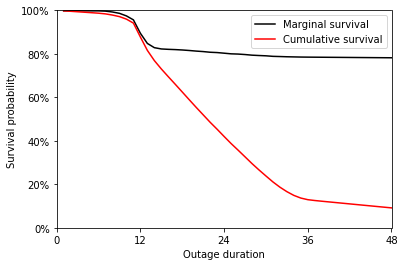

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
cum_survival = erp_response["mean_cumulative_survival_by_duration"]
mar_survival = erp_response["mean_marginal_survival_by_duration"]
max_duration = len(cum_survival)
outage_durations = range(1, max_duration + 1)

#Creates line plots. As set up is plotting marginal and cumulative survival on same plot. 
plt.plot(outage_durations, mar_survival, linestyle='-', label = "Marginal survival", color = "black")
plt.plot(outage_durations, cum_survival, linestyle='-', label = "Cumulative survival", color = "red")
plt.xlabel("Outage duration")
plt.ylabel("Survival probability")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylim([0,1])
plt.xlim([1,max_duration])
time_list =   [120, 48, 24,  12, 8]
time_ticks = [12,   6,  3,   2, 1]

tick_mark_step = 24
for i in range(len(time_list)):
    if max_duration < time_list[i]:
        tick_mark_step = time_ticks[i]

plt.xticks(range(0, max_duration+1, tick_mark_step))
plt.legend()
plt.show()

## Save API response into a JSON file for later use

In [ ]:
response_save = api_response
file_name_to_save = "response_1"
with open(os.path.join(outputs_path, file_name_to_save + ".json"), 'w') as fp:
    json.dump(response_save, fp)